<a href="https://colab.research.google.com/github/hye0ngyun/TIL/blob/main/5_Mnist_%EC%8B%A4%EC%8A%B5%2C_%EB%B0%B0%EC%B9%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mnist 손글씨 데이터셋 분류 추론 모델 만들기

## 텐서플로우로 Mnist 데이터 불러오기

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# mnist 데이터 세트 로딩
from tensorflow.keras import datasets
mnist = datasets.mnist

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

## 데이터 형상 확인

In [4]:
# 60000장의 이미지 데이터(28, 28 픽셀)와 정답(이미지의 레이블: 1, 2 ...)
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

## 첫 번째 데이터를 시각화해 확인해보기

In [5]:
img = X_train[0]
label = y_train[0]
img.shape

(28, 28)

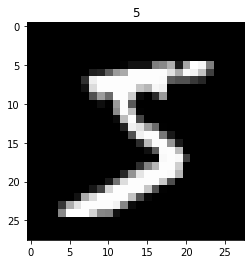

In [6]:
# plt.imshow()함수는 픽셀값을 이미지로 변환시켜 보여준다. gray는 이미지의 색상
# img는 0번 이미지
plt.imshow(img, 'gray')
# label은 0번 이미지의 정답
plt.title(label)
plt.show()

## 데이터 전처리
- 이미지 데이터를 신경망에 입력으로 넣기 위해서는 shape이 (28, 28)같이 2차원이 아닌, (784)처럼 1차원 배열로 입력해야한다.
- 즉, mnist 이미지 데이터를 입력으로 넣기 위해 shape을 1차원 배열로 변경해야한다.

In [7]:
X_train.shape

(60000, 28, 28)

In [8]:
# X_train.shape[0]은 60000, literal을 쓰는 것 보다 변수를 사용하는게 좋다.
# ndarray.reshape()함수에 -1을 넣게 되면 남은 차원의 수를 합쳐버린다. 28 28 => 784
X_train = X_train.reshape(X_train.shape[0], -1).shape

## 신경망의 추론 처리

In [9]:
import pickle

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def softmax(x):
  # 오버플로 대책
  c = np.max(x)
  # 분모
  exp_x = np.exp(x - c)
  # 분자
  sum_exp_x = np.sum(exp_x)
  
  return exp_x / sum_exp_x


# test 데이터만 가져온다.
def get_data():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_test = x_test.reshape(x_test.shape[0], -1)
  return x_test, y_test

# mnist를 추론하기 위한 미리 준비된 가중치와 편향
def init_network():
  with open('sample_weight.pkl', 'rb') as f:
    # network는 딕셔너리 형태로 가중치와 편향을 가져온다.
    network = pickle.load(f)

  return network

def predict(network, x):
  W1, W2, W3 = network['W1'], network['W2'], network['W3']
  b1, b2, b3 = network['b1'], network['b2'], network['b3']

  # 입력층(0)
  a1 = np.dot(x, W1) + b1
  z1 = sigmoid(a1)

  # 은닉층(1)
  a2 = np.dot(a1, W2) + b2
  z2 = sigmoid(a2)

  # 은닉층(2) - 출력
  a3 = np.dot(a2, W3) + b3
  y = softmax(a3)

  return y
  

In [10]:
network = init_network()
network.keys()

dict_keys(['b2', 'W1', 'b1', 'W2', 'W3', 'b3'])

In [11]:
# network 로드
network = init_network()
# datasets 로드
(X_test, y_test) = get_data()

# 0번 이미지 예측해보기
pred = predict(network, X_test[0])
print(pred.argmax(), y_test[0])
print(pred.argmax() == y_test[0])

7 7
True


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


### 예측한 이미지 확인해보기

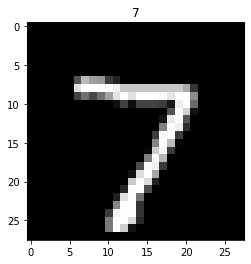

In [12]:
# ndarray.reshape()함수는 값을 리턴하지만, 값자체를 바꾸진 않는다.
# 값을 재정의 하지 않는이상 원본 데이터가 바뀌지 않는다.(shape - (784))
plt.imshow(X_test[0].reshape(28, 28), 'gray')
plt.title(y_test[0])
plt.show()

### 정확도 구해보기
- 하나의 데이터를 추론해봤으니, 전체 데이터에 예측을 수행해보고 얼마나 정확히(많이) 맞추는지 확인해본다.

In [13]:
# 맞출 때 마다 1씩 증가
accuracy_cnt = 0

for i in range(len(X_test)):
  pred = predict(network, X_test[i])
  # 예측된 것과 정답이 맞다면 cnt 1 증가
  if pred.argmax() == y_test[i]:
    accuracy_cnt += 1
print(f'accuracy: {accuracy_cnt / len(X_test)}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


accuracy: 0.769


accuracy: `0.769`라는건 `76.9%`의 정확도를 가지고 있다는 뜻이다.

### 배치 처리
- 컴퓨터의 입장에선 데이터를 하나씩 예측하는 것보다, 넘파이 배열을 이용해 한 번에 묶음(batch)으로 예측하는것이 더욱 효율적이다.
- **묶은 입력 데이터**, 묶음  

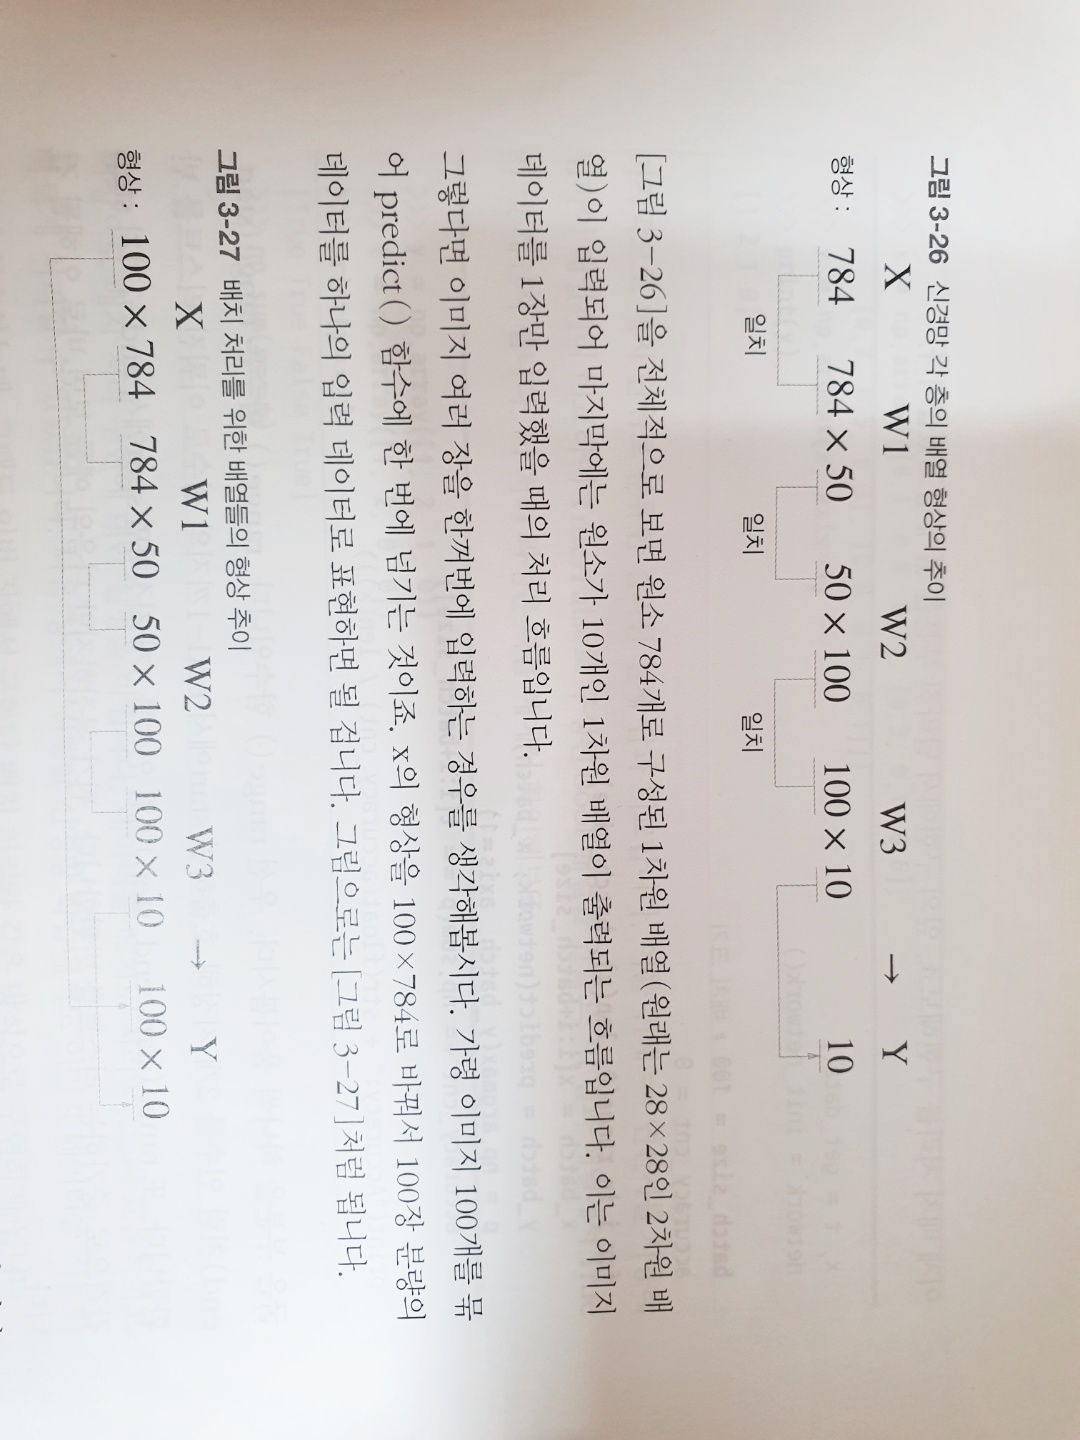


In [14]:
# 맞출 때 마다 1씩 증가
accuracy_cnt = 0

# 배치 크기
batch_size = 100

# range의 start: 0, end: 이미지 총 개수, step: 배치 크기
# 0부터 100, 100부터 200, 200부터 300...
# 100장씩 묶어서 예측하는것이다.
for i in range(0, len(X_test), batch_size):
  X_batch = X_test[i:i+batch_size]
  pred = predict(network, X_batch)
  # pred는 ndarray 넘파이 함수 사용 가능
  # 예측된 것과 정답이 맞다면 cnt 1 증가
  pred = np.argmax(pred, axis=1)
  accuracy_cnt += np.sum(pred == y_test[i:i+batch_size])

print(f'accuracy: {accuracy_cnt / len(X_test)}')

accuracy: 0.0991


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


### 배치를 줬더니 오히려 정확도가 감소했다.
- 처음엔 오류인줄 알았는데 batch_size를 1로 하니 위에서 배치를 안줬던 결과와 동일한 것으로 보아 코드에 문제는 없다.
- 구글에 검색해보니 너무 큰 batch size는 모델의 정확도를 낮춘다는 내용을 찾을 수 있었다.  
[page link](https://nyanye.com/paper/2020/05/30/good-batchsize/)

In [15]:
# 맞출 때 마다 1씩 증가
accuracy_cnt = 0

# 배치 크기
batch_size = 1

# range의 start: 0, end: 이미지 총 개수, step: 배치 크기
# 0부터 100, 100부터 200, 200부터 300...
# 100장씩 묶어서 예측하는것이다.
for i in range(0, len(X_test), batch_size):
  X_batch = X_test[i:i+batch_size]
  pred = predict(network, X_batch)
  # pred는 ndarray 넘파이 함수 사용 가능
  # 예측된 것과 정답이 맞다면 cnt 1 증가
  pred = np.argmax(pred, axis=1)
  accuracy_cnt += np.sum(pred == y_test[i:i+batch_size])

print(f'accuracy: {accuracy_cnt / len(X_test)}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


accuracy: 0.769


batch_size를 1로 했을 경우 배치가 없는 경우와 정확도가 `0.769`로 동일하다.

# 정리
- 신경망에서는 활성화 함수로 시그모이드 함수와 ReLU 함수 같은 매끄럽게 변화하는 함수를 이용한다.
- 넘파이의 다차원 배열을 잘 사용하면 신경망을 효율적으로 구현할 수 있다.
- 기계학습의 문제는 크게 회귀와 분류로 나눌 수 있다.
- 출력층의 활성화 함수로는 회귀에서는 주로 항등 함수를, 분류에서는 주로 소프트맥스 함수를 이용한다.
- 분류에서는 출력층의 뉴런 수를 분류하려는 클래스 수와 같게 설정한다.
- 입력 데이터를 묶은 것을 배치라 하며, 추론 처리를 이 배치 단위로 진행하면 결과를 훨씬 빠르게 얻을 수 있다.